# 感染可能性予測モデル

### コロナ禍による自然災害時の避難計画の作成
目的：クラスターを発生させないように各避難施設へ割り振るモデルを組む

## Datasetについて
- 元データは[ここ](https://www.covidanalytics.io/dataset)
- [Documentation](https://www.covidanalytics.io/dataset_documentation)
- 2019年１２月から2020年の４月
- MITの研究者が論文を読んで集めた数値データ
- 病院で行われた研究から得られたものである。無症状患者の有病率を考慮できていない。
- 各行はcohort、つまり研究対象となった集団である。
- 列は大まかに以下のカテゴリーである
    - 人口統計学的情報（例：コホート内の患者数、集計された年齢と性別の統計）
    - 併存疾患情報（糖尿病、高血圧の有病率など)
    - 症状（発熱、咳、咽頭痛などを含む)
    - 治療法（抗生物質、挿管などを含む)
    - 標準的な検査値（リンパ球数、血小板などを含む)
    - 転帰（退院、入院期間、死亡などを含む)
- 追加で以下も調査
    - 死亡率、ICUおよび入院期間
    - 主要症状（発熱、咳、息切れ、疲労、下痢）
    - 一般的な併存疾患（高血圧、糖尿病 
- 死亡率または退院率の報告には一貫性がない。死亡率のみを報告しているものもあれば、退院率のみを報告しているものもある


- 引用
@online{bertsimas2020covidClinicalOutcomes, author = {Bertsimas, Dimitris and Bandi, Hari and Boussioux, Leonard and Cory-Wright, Ryan and Delarue, Arthur and Digalakis, Vasileios and Gilmour, Samuel and Graham, Justin and Kim, Adam and Lahlou Kitane, Driss and Lin, Zhen and Lukin, Galit and Li, Michael and Mingardi, Luca and Na, Liangyuan and Orfanoudaki, Agni and Papalexopoulos, Theodore and Paskov, Ivan and Pauphilet, Jean and Skali Lami, Omar and Sobiesk, Matthew and Stellato, Bartolomeo and Carballo, Kimberly and Wang, Yuchen and Wiberg, Holly and Zeng, Cynthia}, title = {An Aggregated Dataset of Clinical Outcomes for COVID-19 Patients}, url = {http://www.covidanalytics.io/dataset_documentation}, year={2020} }

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
df = pd.read_csv("./data/covid_analytics_clinical_data.csv")
#表示列の増加
pd.set_option('display.max_columns', 162)
#df.head()

## データの列名一覧

In [79]:
df.columns.values

array(['ID', 'SUB_ID', 'Country', 'Province/State', 'Study Pop Size (N)',
       'Proportion of values entered in row (%)', 'Paper Title',
       'Journal', 'Author', 'Source', 'Date Added', 'Language',
       'Peer-Reviewed? (As of Date Added)',
       'Study Type: Observational or Randomized Clinical Trial (RCT)?',
       'Study start date (mm/dd/yyyy)', 'Study end date (mm/dd/yyyy)',
       'Study length (days)', 'Overall study population or subgroup?',
       'Subgroup', 'Positive/negative cases', 'End-point vs Active',
       'Survivors', 'Discharged', 'Contains Any Treatment?',
       'ICU vs. non-ICU', 'Severity', 'Ventilation', 'Median Age',
       'Mean Age', 'Age SD', 'Age LQ', 'Age UQ', '% Healthcare Worker',
       '% Male', '% White or European', '% African American', '% Asian',
       '% Hispanic or Latino', '% Multiple ethnicities or other',
       'Exposure history (%)', 'Exposure - Wuhan Travel (%)',
       'Exposure - Personal Contact (%)',
       'Incubation period (

＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊

メモ：年齢/性別/平熱/熱/心拍数/既往症/呼吸不全の有無/息切れの有無

＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊

### 選んだ変数
- Mean Age
- Median Age
- Male
- Race
    - White or European
    - African American
    - Asian
    - Hispanic or Latino
    - Multiple ethnicities or other
    - Exposure history

- Smoking history
- Current drinker
- BMI
- Any Comorbidity
    - Hypertension
    - Diabetes
    - Cardiovascular Disease (incl. CAD)
    - Chronic obstructive lung (COPD)
    - Cancer (Any)
    - Liver Disease (any)
    - Cerebrovascular Disease
    - Chronic kidney/renal disease
    - Other
- Fever (temperature ≥37·3°C)
- Average temperature (celsius)
- symptoms
    - Respiratory rate > 24 breaths per min
    - Cough
    - Shortness of Breath (dyspnoea)
    - Headache
    - Sputum (/Expectoration)
    - Myalgia (Muscle Pain)
    - Fatigue
    - Upper air-way congestion
    - Diarrhoea
    - Nausea or Vomiting
    - Loss of Appetite/Anorexia
    - Sore Throat/Stuffy Nose
    - Chills
    - Chest Pain
    - Loss of smell/taste

In [80]:
"""
col_names = ['Median Age', 'Mean Age',  '% Male', '% White or European', '% African American', '% Asian',
       '% Hispanic or Latino', '% Multiple ethnicities or other',
          'Fever (temperature ≥37·3°C)','Average temperature (celsius)','Max temperature (celsius)',
             'Smoking history', 'Current drinker', 'BMI',
         'Any Comorbidity', 'Hypertension', 'Diabetes',
       'Cardiovascular Disease (incl. CAD)',
       'Chronic obstructive lung (COPD)', 'Cancer (Any)',
       'Liver Disease (any)', 'Cerebrovascular Disease',
       'Chronic kidney/renal disease', 'Other',
         'Respiratory rate > 24 breaths per min', 'Cough',
       'Shortness of Breath (dyspnoea)', 'Headache',
       'Sputum (/Expectoration)', 'Myalgia (Muscle Pain)', 'Fatigue',
       'Upper air-way congestion', 'Diarrhoea', 'Nausea or Vomiting',
       'Loss of Appetite/Anorexia', 'Sore Throat/Stuffy Nose', 'Chills',
       'Chest Pain', 'Loss of smell/taste',
            "Mortality"]
"""

'\ncol_names = [\'Median Age\', \'Mean Age\',  \'% Male\', \'% White or European\', \'% African American\', \'% Asian\',\n       \'% Hispanic or Latino\', \'% Multiple ethnicities or other\',\n          \'Fever (temperature ≥37·3°C)\',\'Average temperature (celsius)\',\'Max temperature (celsius)\',\n             \'Smoking history\', \'Current drinker\', \'BMI\',\n         \'Any Comorbidity\', \'Hypertension\', \'Diabetes\',\n       \'Cardiovascular Disease (incl. CAD)\',\n       \'Chronic obstructive lung (COPD)\', \'Cancer (Any)\',\n       \'Liver Disease (any)\', \'Cerebrovascular Disease\',\n       \'Chronic kidney/renal disease\', \'Other\',\n         \'Respiratory rate > 24 breaths per min\', \'Cough\',\n       \'Shortness of Breath (dyspnoea)\', \'Headache\',\n       \'Sputum (/Expectoration)\', \'Myalgia (Muscle Pain)\', \'Fatigue\',\n       \'Upper air-way congestion\', \'Diarrhoea\', \'Nausea or Vomiting\',\n       \'Loss of Appetite/Anorexia\', \'Sore Throat/Stuffy Nose\', \'

In [81]:
#特徴量の重要度20以上
col_names = ['Positive/negative cases','Median Age', 'Mean Age',  '% Male', 'Any Comorbidity', 'Fever (temperature ≥37·3°C)', 'Cough', 
             'Chronic obstructive lung (COPD)', 'Diabetes', 'Hypertension', 'Cardiovascular Disease (incl. CAD)',
            'Fatigue', 'Other', 'Shortness of Breath (dyspnoea)', 'Smoking history', 'BMI', 'Cancer (Any)',
            '% Asian', 'Cerebrovascular Disease','Diarrhoea',"Mortality"]
len(col_names)

21

In [82]:
df = df[col_names]
df.head(20)

,Positive/negative cases,Median Age,Mean Age,% Male,Any Comorbidity,Fever (temperature ≥37·3°C),Cough,Chronic obstructive lung (COPD),Diabetes,Hypertension,Cardiovascular Disease (incl. CAD),Fatigue,Other,Shortness of Breath (dyspnoea),Smoking history,BMI,Cancer (Any),% Asian,Cerebrovascular Disease,Diarrhoea,Mortality
0,Positive only,56.0,NaN,62.30%,47.60%,94%,79%,3.00%,19.00%,30%,8.00%,23.03%,12.00%,NaN,5.76%,NaN,1.68%,100%,NaN,4.71%,0.28
1,Positive only,69.0,NaN,70.37%,66.67%,94.44%,72.22%,7.41%,31.48%,48.15%,24.07%,27.78%,20.37%,NaN,9.26%,NaN,0.00%,100%,NaN,3.70%,1
2,Positive only,52.0,NaN,59.12%,40.15%,94.16%,81.75%,1.46%,13.87%,23.36%,1.46%,21.17%,8.03%,NaN,4.38%,NaN,7.00%,100%,NaN,5.11%,0
3,Positive only,58.0,NaN,60.30%,NaN,91.50%,NaN,NaN,11.60%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00%,100%,6.50%,2.06%,0.16
4,Positive only,58.0,NaN,61.60%,NaN,89.90%,NaN,NaN,10.10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10%,100%,5.10%,4.20%,0.15
5,Positive only,58.0,NaN,59.00%,NaN,93.00%,NaN,NaN,13.00%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00%,100%,8.00%,0%,0.17
6,Positive only,50.0,49.50,52%,26%,73%,59%,11%,12%,15%,10%,9%,16%,42%,NaN,NaN,5%,100%,7%,4%,0.04
7,Positive only,NaN,44.90,27.00%,27.00%,0.00%,0.00%,7%,20%,13%,20%,0%,7%,0.00%,NaN,NaN,7%,100%,7%,0%,0
8,Positive only,NaN,48.80,52.00%,24.00%,86.00%,71.00%,14%,10%,5%,5%,9%,15%,43.00%,NaN,NaN,5%,100%,5%,5.00%,0
9,Positive only,NaN,52.30,67.00%,30.00%,90.00%,70.00%,10%,10%,23%,10%,5%,20%,43.00%,NaN,NaN,7%,100%,10%,3.00%,0.07


## データの前処理

In [83]:
#空白はアンダーバーに変換
df = df.rename(columns=lambda s: s.replace("% ",""))
df = df.rename(columns=lambda s: s.replace(" ","_"))
print(df.columns)

Index(['Positive/negative_cases', 'Median_Age', 'Mean_Age', 'Male',
       'Any_Comorbidity', 'Fever_(temperature_≥37·3°C)', 'Cough',
       'Chronic_obstructive_lung_(COPD)', 'Diabetes', 'Hypertension',
       'Cardiovascular_Disease_(incl._CAD)', 'Fatigue', 'Other',
       'Shortness_of_Breath_(dyspnoea)', 'Smoking_history', 'BMI',
       'Cancer_(Any)', 'Asian', 'Cerebrovascular_Disease', 'Diarrhoea',
       'Mortality'],
      dtype='object')


In [84]:
#余計な記号削除
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

,Positivenegative_cases,Median_Age,Mean_Age,Male,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality
0,Positive only,56.0,NaN,62.30%,47.60%,94%,79%,3.00%,19.00%,30%,8.00%,23.03%,12.00%,NaN,5.76%,NaN,1.68%,100%,NaN,4.71%,0.28
1,Positive only,69.0,NaN,70.37%,66.67%,94.44%,72.22%,7.41%,31.48%,48.15%,24.07%,27.78%,20.37%,NaN,9.26%,NaN,0.00%,100%,NaN,3.70%,1
2,Positive only,52.0,NaN,59.12%,40.15%,94.16%,81.75%,1.46%,13.87%,23.36%,1.46%,21.17%,8.03%,NaN,4.38%,NaN,7.00%,100%,NaN,5.11%,0
3,Positive only,58.0,NaN,60.30%,NaN,91.50%,NaN,NaN,11.60%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00%,100%,6.50%,2.06%,0.16
4,Positive only,58.0,NaN,61.60%,NaN,89.90%,NaN,NaN,10.10%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10%,100%,5.10%,4.20%,0.15


In [85]:
"""for i in df.columns:
    for j in range(len(df[i])):
        #print(df[i][j])
        if df[i][j] in '%':
            df[i][j] == df[i][j].replace('%','')
"""

"for i in df.columns:\n    for j in range(len(df[i])):\n        #print(df[i][j])\n        if df[i][j] in '%':\n            df[i][j] == df[i][j].replace('%','')\n"

In [86]:
#％表記の処理
for i in df.columns:
    if df["%s"%i].dtype == object:
        #df["%s"%i] = df["%s"%i].str.extract(r'(\d+)').astype(float)
        #df["%s"%i] = df["%s"%i].str[0:-1]
        df["%s"%i] = df["%s"%i].str.strip("%")
    else:
        pass
    print('%s"OK'%i)

Positivenegative_cases"OK
Median_Age"OK
Mean_Age"OK
Male"OK
Any_Comorbidity"OK
Fever_temperature_373C"OK
Cough"OK
Chronic_obstructive_lung_COPD"OK
Diabetes"OK
Hypertension"OK
Cardiovascular_Disease_incl_CAD"OK
Fatigue"OK
Other"OK
Shortness_of_Breath_dyspnoea"OK
Smoking_history"OK
BMI"OK
Cancer_Any"OK
Asian"OK
Cerebrovascular_Disease"OK
Diarrhoea"OK
Mortality"OK


In [87]:
df.replace(r'^\s*$', np.nan, regex=True)

,Positivenegative_cases,Median_Age,Mean_Age,Male,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality
0,Positive only,56.0,NaN,62.30,47.60,94,79,3.00,19.00,30,8.00,23.03,12.00,NaN,5.76,NaN,1.68,100,NaN,4.71,0.28
1,Positive only,69.0,NaN,70.37,66.67,94.44,72.22,7.41,31.48,48.15,24.07,27.78,20.37,NaN,9.26,NaN,0.00,100,NaN,3.70,1
2,Positive only,52.0,NaN,59.12,40.15,94.16,81.75,1.46,13.87,23.36,1.46,21.17,8.03,NaN,4.38,NaN,7.00,100,NaN,5.11,0
3,Positive only,58.0,NaN,60.30,NaN,91.50,NaN,NaN,11.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,100,6.50,2.06,0.16
4,Positive only,58.0,NaN,61.60,NaN,89.90,NaN,NaN,10.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10,100,5.10,4.20,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Positive only,NaN,NaN,NaN,66.70,NaN,NaN,26.30,46.50,75.80,13.10,NaN,NaN,NaN,NaN,NaN,3.00,NaN,NaN,NaN,0.1
535,Positive only,NaN,NaN,NaN,NaN,NaN,NaN,18.80,46.20,86.30,47,NaN,NaN,NaN,NaN,NaN,5.10,NaN,NaN,NaN,0.36
536,Positive only,60.0,NaN,NaN,74.90,NaN,NaN,21.50,41.70,69.60,25.10,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,0.16
537,Positive only,64.5,NaN,NaN,68,NaN,NaN,12,32,54,30,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,0.23


In [88]:
df['Positivenegative_cases'].value_counts()

Positive only                        505
Positive                              12
Positive and Negative/Unconfirmed     10
Negative only                          5
Positive Only                          5
Name: Positivenegative_cases, dtype: int64

In [89]:
df.dtypes

Positivenegative_cases              object
Median_Age                         float64
Mean_Age                           float64
Male                                object
Any_Comorbidity                     object
Fever_temperature_373C              object
Cough                               object
Chronic_obstructive_lung_COPD       object
Diabetes                            object
Hypertension                        object
Cardiovascular_Disease_incl_CAD     object
Fatigue                             object
Other                               object
Shortness_of_Breath_dyspnoea        object
Smoking_history                     object
BMI                                float64
Cancer_Any                          object
Asian                               object
Cerebrovascular_Disease             object
Diarrhoea                           object
Mortality                           object
dtype: object

In [90]:
df.isnull().sum()

Positivenegative_cases               2
Median_Age                         147
Mean_Age                           247
Male                                59
Any_Comorbidity                    298
Fever_temperature_373C             142
Cough                              169
Chronic_obstructive_lung_COPD      243
Diabetes                           174
Hypertension                       194
Cardiovascular_Disease_incl_CAD    199
Fatigue                            301
Other                              334
Shortness_of_Breath_dyspnoea       275
Smoking_history                    371
BMI                                495
Cancer_Any                         271
Asian                               62
Cerebrovascular_Disease            354
Diarrhoea                          249
Mortality                           75
dtype: int64

In [91]:
df.head(10)

,Positivenegative_cases,Median_Age,Mean_Age,Male,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality
0,Positive only,56.0,NaN,62.30,47.60,94,79,3.00,19.00,30,8.00,23.03,12.00,NaN,5.76,NaN,1.68,100,NaN,4.71,0.28
1,Positive only,69.0,NaN,70.37,66.67,94.44,72.22,7.41,31.48,48.15,24.07,27.78,20.37,NaN,9.26,NaN,0.00,100,NaN,3.70,1
2,Positive only,52.0,NaN,59.12,40.15,94.16,81.75,1.46,13.87,23.36,1.46,21.17,8.03,NaN,4.38,NaN,7.00,100,NaN,5.11,0
3,Positive only,58.0,NaN,60.30,NaN,91.50,NaN,NaN,11.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.00,100,6.50,2.06,0.16
4,Positive only,58.0,NaN,61.60,NaN,89.90,NaN,NaN,10.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.10,100,5.10,4.20,0.15
5,Positive only,58.0,NaN,59.00,NaN,93.00,NaN,NaN,13.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,100,8.00,0,0.17
6,Positive only,50.0,49.5,52,26,73,59,11,12,15,10,9,16,42,NaN,NaN,5,100,7,4,0.04
7,Positive only,NaN,44.9,27.00,27.00,0.00,0.00,7,20,13,20,0,7,0.00,NaN,NaN,7,100,7,0,0
8,Positive only,NaN,48.8,52.00,24.00,86.00,71.00,14,10,5,5,9,15,43.00,NaN,NaN,5,100,5,5.00,0
9,Positive only,NaN,52.3,67.00,30.00,90.00,70.00,10,10,23,10,5,20,43.00,NaN,NaN,7,100,10,3.00,0.07


In [92]:
#欠損値の処理
df = df.dropna(subset=['Mortality'])
age = ['Median_Age','Mean_Age','Male']
df[age] = df[age].fillna(df[age].mean())
df = df.fillna(0)

df.head(10)

,Positivenegative_cases,Median_Age,Mean_Age,Male,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality
0,Positive only,56.000000,50.680772,62.30,47.60,94,79,3.00,19.00,30,8.00,23.03,12.00,0,5.76,0.0,1.68,100,0,4.71,0.28
1,Positive only,69.000000,50.680772,70.37,66.67,94.44,72.22,7.41,31.48,48.15,24.07,27.78,20.37,0,9.26,0.0,0.00,100,0,3.70,1
2,Positive only,52.000000,50.680772,59.12,40.15,94.16,81.75,1.46,13.87,23.36,1.46,21.17,8.03,0,4.38,0.0,7.00,100,0,5.11,0
3,Positive only,58.000000,50.680772,60.30,0,91.50,0,0,11.60,0,0,0,0,0,0,0.0,3.00,100,6.50,2.06,0.16
4,Positive only,58.000000,50.680772,61.60,0,89.90,0,0,10.10,0,0,0,0,0,0,0.0,5.10,100,5.10,4.20,0.15
5,Positive only,58.000000,50.680772,59.00,0,93.00,0,0,13.00,0,0,0,0,0,0,0.0,1.00,100,8.00,0,0.17
6,Positive only,50.000000,49.500000,52,26,73,59,11,12,15,10,9,16,42,0,0.0,5,100,7,4,0.04
7,Positive only,52.823955,44.900000,27.00,27.00,0.00,0.00,7,20,13,20,0,7,0.00,0,0.0,7,100,7,0,0
8,Positive only,52.823955,48.800000,52.00,24.00,86.00,71.00,14,10,5,5,9,15,43.00,0,0.0,5,100,5,5.00,0
9,Positive only,52.823955,52.300000,67.00,30.00,90.00,70.00,10,10,23,10,5,20,43.00,0,0.0,7,100,10,3.00,0.07


In [93]:
#Mortalityの表記揺れ修正
df["Mortality"] = df["Mortality"].replace("na","0")

In [94]:
#エラー出る列は無視してfloatへ変換
for i in df.columns:
    try:
        df[i] = df[i].astype("float64")
    except:
        pass

In [95]:
df = pd.get_dummies(df)

In [96]:
df.dtypes

Median_Age                                                  float64
Mean_Age                                                    float64
Male                                                        float64
Any_Comorbidity                                             float64
Fever_temperature_373C                                      float64
Cough                                                       float64
Chronic_obstructive_lung_COPD                               float64
Diabetes                                                    float64
Hypertension                                                float64
Cardiovascular_Disease_incl_CAD                             float64
Fatigue                                                     float64
Other                                                       float64
Shortness_of_Breath_dyspnoea                                float64
Smoking_history                                             float64
BMI                                             

In [97]:
df["Mortality"] = df["Mortality"].replace("na","0")

In [98]:
# 12/22追記
df=df.drop('Male', axis=1)
df=df.drop('Median_Age', axis=1)

In [99]:
df.head()

,Mean_Age,Any_Comorbidity,Fever_temperature_373C,Cough,Chronic_obstructive_lung_COPD,Diabetes,Hypertension,Cardiovascular_Disease_incl_CAD,Fatigue,Other,Shortness_of_Breath_dyspnoea,Smoking_history,BMI,Cancer_Any,Asian,Cerebrovascular_Disease,Diarrhoea,Mortality,Positivenegative_cases_Negative only,Positivenegative_cases_Positive,Positivenegative_cases_Positive Only,Positivenegative_cases_Positive and Negative/Unconfirmed,Positivenegative_cases_Positive only
0,50.680772,47.60,94.00,79.00,3.00,19.00,30.00,8.00,23.03,12.00,0.0,5.76,0.0,1.68,100.0,0.0,4.71,0.28,0,0,0,0,1
1,50.680772,66.67,94.44,72.22,7.41,31.48,48.15,24.07,27.78,20.37,0.0,9.26,0.0,0.00,100.0,0.0,3.70,1.00,0,0,0,0,1
2,50.680772,40.15,94.16,81.75,1.46,13.87,23.36,1.46,21.17,8.03,0.0,4.38,0.0,7.00,100.0,0.0,5.11,0.00,0,0,0,0,1
3,50.680772,0.00,91.50,0.00,0.00,11.60,0.00,0.00,0.00,0.00,0.0,0.00,0.0,3.00,100.0,6.5,2.06,0.16,0,0,0,0,1
4,50.680772,0.00,89.90,0.00,0.00,10.10,0.00,0.00,0.00,0.00,0.0,0.00,0.0,5.10,100.0,5.1,4.20,0.15,0,0,0,0,1


## csvファイルへ書き出し

In [100]:
df.to_csv('data/cleansed.csv')

## statsmodelsを使用して回帰分析

In [101]:
from sklearn.model_selection import train_test_split
import scipy.stats


X = df.drop(['Mortality'], axis=1)
y = df['Mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =0.8, random_state=0)
import statsmodels.api as sm

# 回帰モデル作成
mod = sm.OLS(y_train, sm.add_constant(X_train))

# 訓練
result = mod.fit() 

# 統計サマリを表示
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Mortality   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     23.32
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           1.57e-52
Time:                        22:29:00   Log-Likelihood:                 49.906
No. Observations:                 371   AIC:                            -57.81
Df Residuals:                     350   BIC:                             24.43
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [102]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df.drop('Mortality',axis=1).values         # 説明変数（Numpyの配列）
Y = df['Mortality'].values         # 目的変数（Numpyの配列）

lr.fit(X_train, y_train)
# 回帰係数
print(lr.coef_)
 
# 切片 (誤差)
print(lr.intercept_)
 
# 決定係数
print(lr.score(X, Y))

[ 2.56934344e-03  2.86840294e-03 -7.94777943e-04 -1.27659501e-03
 -2.01254602e-04  1.17036138e-03  1.84416762e-03  3.00715552e-03
 -2.01657292e-04  9.29267503e-05  1.32615836e-03 -2.83972209e-03
  2.40644523e-03  2.26382768e-03  1.10502397e-03  3.77078681e-03
 -3.96203535e-04 -1.01372903e-16 -1.17701596e-01  1.69287984e-01
  4.36789786e-03 -5.59542858e-02]
-0.06248151810022706
0.5022374698767957


505    0.670658
499   -0.021825
162   -0.004143
106    0.121305
446    0.016647
         ...   
268   -0.362048
327    0.307267
397    0.019408
58    -0.327458
188   -0.268049
Name: Mortality, Length: 93, dtype: float64


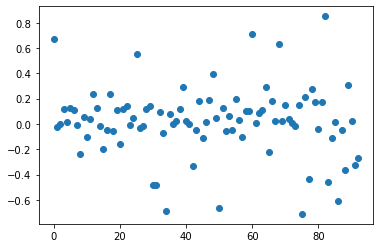

In [103]:
#予測と実際値の差をplot
y_pred=lr.predict(X_test)
a=[i for i in range(len(y_test))]

b=(y_pred-y_test)
plt.scatter(a,b)
print(y_pred-y_test)

## 死亡率をランク分け

- A(0.1%以下)
- B（0.1~1)
- C(1~5)
- D(5~20)
- E(20~50)
- F(50~)

In [104]:
df['Mortality'].head()

0    0.28
1    1.00
2    0.00
3    0.16
4    0.15
Name: Mortality, dtype: float64

In [105]:
df1 = df
#　インデックス振り直す
df1 = df.reset_index()

In [106]:
df1['danger_level'] = 'Z'

In [107]:
for i in range(len(df1)):
    p = df1['Mortality'][i]
    if p <= 0.001:
        df1.at[i,'danger_level'] = '1'
    elif 0.001 < p <= 0.01:
        df1.at[i,'danger_level'] = '2'
    elif 0.01 < p <= 0.05:
        df1.at[i,'danger_level'] = '3'
    elif 0.05 < p <= 0.2:
        df1.at[i,'danger_level'] = '4'
    elif 0.2 < p <= 0.5:
        df1.at[i,'danger_level'] = '5'
    else:
        df1.at[i,'danger_level'] = '6'      

In [108]:
df1['danger_level']

0      5
1      6
2      1
3      4
4      4
      ..
459    3
460    4
461    5
462    4
463    5
Name: danger_level, Length: 464, dtype: object

In [109]:
df1['danger_level'].value_counts()

1    262
4     65
6     63
5     38
2     19
3     17
Name: danger_level, dtype: int64

### 再びCSVに書き出し

In [110]:
df1.to_csv('data/cleansed_ver2.csv')